In [1]:
from __future__ import division
import pandas as pd
import sys
from sys import argv
import re
import numpy as np
from nltk.tokenize import sent_tokenize
import glob
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
def open_bow_df(bow_name):
    
    bow_df_file = pd.read_csv(bow_name, sep = "\t")
    
    return bow_df_file

In [3]:
BOW_df_SS = open_bow_df("../../Results/Full_MEDLINE_Results_Single_Sen/Bag_of_Words_df_Single_Sen.tsv")

In [21]:
def manual_TrTe_split(bow_df, random_state, test_set_prop):
    """Split BOW Data Frame so no two interactions occur both in Test and in Train sets
    The code will try to get the around the proportion given by test_set_prop where train set
    will be 1-test_set_prop."""
    
    np.random.seed(random_state)
    
    #Get a Full list of proteins
    real_x = bow_df["Real_ID_x"].tolist()
    real_y = bow_df["Real_ID_y"].tolist()
    full_protein_list = list(set(real_x + real_y)) #A set because it is faster to search it!
    
    train_size = len(full_protein_list) - int(len(full_protein_list)*test_set_prop)
    train_prots = set(np.random.choice(np.array(full_protein_list), train_size, replace = False))
    test_prots = set(full_protein_list) - set(train_prots)
    
    col_names = ["Real_ID_x", "Real_ID_y", "Mode", "Text"]
    train = pd.DataFrame(columns = col_names)
    test = pd.DataFrame(columns = col_names)
    
    for i,r in bow_df.iterrows():
        if r["Real_ID_x"] in train_prots and r["Real_ID_y"] in train_prots:
            temp_df = pd.DataFrame(r).T #Dirty but works
            train = train.append(temp_df)
            del temp_df
        elif r["Real_ID_x"] in test_prots and r["Real_ID_y"] in test_prots:
            temp_df = pd.DataFrame(r).T #Dirty but works
            test = test.append(temp_df)
            del temp_df
        else:
            pass
    
    return train.reset_index(drop = True), test.reset_index(drop = True)

In [22]:
train_bow_df, test_bow_df = manual_TrTe_split(BOW_df_SS, 1000, 0.3)

In [34]:
train_data = train_bow_df[["Real_ID_x", "Real_ID_y", "Text"]]
train_labels = train_bow_df["Mode"].tolist()
test_data = test_bow_df[["Real_ID_x", "Real_ID_y", "Text"]]
test_labels = test_bow_df["Mode"].tolist()

In [7]:
def texts_to_words( raw_text ):
	# Function to convert a raw text to a string of words
	# The input is a single string (a raw text), and 
	# the output is a single string (a preprocessed text)
	#
	# 2. Remove non-letters        
	letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
	#
	# 3. Convert to lower case, split into individual words
	words = letters_only.lower().split()                             
	#
	# 4. In Python, searching a set is much faster than searching
	#   a list, so convert the stop words to a set
	stops = set(stopwords.words("english"))                  
	# 
	# 5. Remove stop words
	meaningful_words = [w for w in words if not w in stops]   
	#
	# 6. Join the words back into one string separated by space, 
	# and return the result.
	return( " ".join( meaningful_words ))

In [8]:
def bag_of_words(data_train, data_test, n_features):
    
    # Get the number of reviews based on the dataframe column size
    num_texts = data_train["Text"].size

    # Initialize an empty list to hold the clean reviews
    print "Cleaning and parsing the training set article sentences...\n"
    clean_train_texts = []
    for i in xrange( 0, num_texts ):
        # If the index is evenly divisible by 1000, print a message
        # if( (i+1)%100 == 0 ):
            # print "Texts %d of %d\n" % ( i+1, num_texts )                                                                    
        clean_train_texts.append( texts_to_words( data_train["Text"][i] ))

    print "Creating the bag of words...\n"
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = n_features) 
    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    train_data_features = vectorizer.fit_transform(clean_train_texts)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    train_data_features = train_data_features.toarray()

    num_texts = len(data_test["Text"])
    clean_test_texts = [] 

    print "Cleaning and parsing the test set movie reviews...\n"
    for i in xrange(0,num_texts):
        # if( (i+1) % 1000 == 0 ):
            # print "Review %d of %d\n" % (i+1, num_texts)
        clean_texts = texts_to_words( data_test["Text"][i] )
        clean_test_texts.append( clean_texts )

    # Get a bag of words for the test set, and convert to a numpy array
    test_data_features = vectorizer.transform(clean_test_texts)
    test_data_features = test_data_features.toarray()

    return train_data_features, test_data_features

In [36]:
def get_accuracy(l_new, l_te):
	"""Calculates the accuracy of predicted labels, based on the given labels

	INPUT: New(Predicted) Labels, Test Labels

	OUTPUT: Error  """

	acc = 0

	for i in range(len(l_te)):
		if l_new[i] == l_te[i]:
			acc += 1

	acc = float(acc / len(l_te))

	return 1-acc

In [11]:
def RF_classifier(train_vector, test_vector, labels_train, labels_test, n_trees, ran_s):
    print "Training the random forest..."

    # Initialize a Random Forest classifier with n_trees trees
    forest = RandomForestClassifier(n_estimators = n_trees, random_state = ran_s) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the response variable
    #
    # This may take a few minutes to run
    forest = forest.fit( train_vector, labels_train)
    probs = forest.predict_proba(test_vec)[:,1] #For ROC Curve
    
    # Use the random forest to make sentiment label predictions
    print "Predicting based on model..."
    result = forest.predict(test_vector)

    error = get_accuracy(result, labels_test)

    return error, probs

In [25]:
train_vec, test_vec = bag_of_words(train_data, test_data, 1000)

Cleaning and parsing the training set article sentences...

Creating the bag of words...

Cleaning and parsing the test set movie reviews...



In [37]:
Error_23, Probs_23 = RF_classifier(train_vec, test_vec, train_labels, test_labels, 100, 23)
Error_8, Probs_8 = RF_classifier(train_vec, test_vec, train_labels, test_labels, 100, 8)

Training the random forest...
Predicting based on model...
Training the random forest...
Predicting based on model...


In [41]:
fpr_rf_23, tpr_rf_23,_ = roc_curve(test_labels, Probs_23)
fpr_rf_8, tpr_rf_8,_ = roc_curve(test_labels, Probs_8)
roc_auc_rf_23 = auc(fpr_rf_23, tpr_rf_23)
roc_auc_rf_8 = auc(fpr_rf_8, tpr_rf_8)

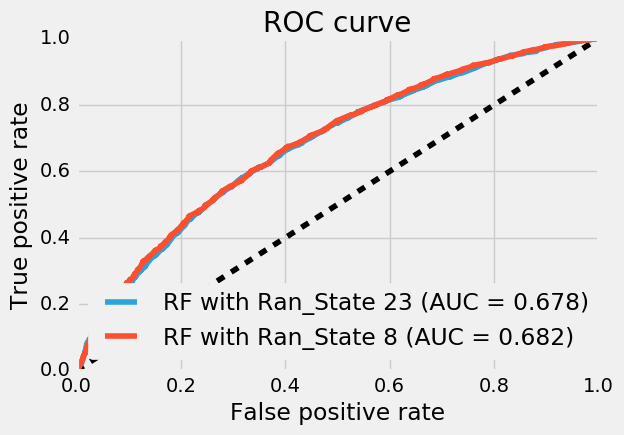

In [42]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_23, tpr_rf_23, label='RF with Ran_State 23 (AUC = ' + '%.3f)'% (roc_auc_rf_23))
plt.plot(fpr_rf_8, tpr_rf_8, label='RF with Ran_State 8 (AUC = ' + '%.3f)'% (roc_auc_rf_8))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [43]:
Error_23

0.2618903545927629

In [44]:
Error_8

0.25971196901851623